In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm, normaltest, lognorm
from sklearn.linear_model import LinearRegression
import itertools

### Colors and data plyground

In [2]:
cand_colors = ['#ffee33', '#cc1111', '#4488cc', '#aaaaaa', '#224499', '#ff3322', '#55aaff', '#33cc33']

# Data acquisition

In [3]:
DATA_PATH = "data/"

In [4]:
elect_df = pd.read_csv(f"{DATA_PATH}elections.csv")

In [5]:
elect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97893 entries, 0 to 97892
Data columns (total 27 columns):
link    97893 non-null object
uik     97893 non-null int64
kom1    97893 non-null object
kom2    97893 non-null object
kom3    97492 non-null object
kom4    0 non-null float64
kom5    0 non-null float64
1       97699 non-null float64
2       97699 non-null float64
3       97699 non-null float64
4       97699 non-null float64
5       97699 non-null float64
6       97699 non-null float64
7       97699 non-null float64
8       97699 non-null float64
9       97699 non-null float64
10      97699 non-null float64
11      97699 non-null float64
12      97699 non-null float64
13      97699 non-null float64
14      97699 non-null float64
15      97699 non-null float64
16      97699 non-null float64
17      97699 non-null float64
18      97699 non-null float64
19      97699 non-null float64
20      97699 non-null float64
dtypes: float64(22), int64(1), object(4)
memory usage: 20.2+ MB


$kom4$ and $kom5$ columns are completely empty and redundant. Some rows representing the polling stations did not participate in 2018 elections and can be dropped from dataset as irrelevant.

In [6]:
elect_df = elect_df.drop(['kom4', 'kom5'], axis=1).dropna(subset=['1'])

Table presentation of 5 random polling stations

In [7]:
elect_df.iloc[np.random.choice(len(elect_df), 5)]

,link,uik,kom1,kom2,kom3,1,2,3,4,5,...,11,12,13,14,15,16,17,18,19,20
53615,http://www.voronezh.vybory.izbirkom.ru/region/...,3616,Воронежская область,Таловская,УИК №3616,875.0,850.0,0.0,416.0,179.0,...,0.0,0.0,3.0,59.0,21.0,499.0,1.0,6.0,1.0,0.0
59793,http://www.kirov.vybory.izbirkom.ru/region/kir...,164,Кировская область,Вятскополянская городская,УИК №164,2516.0,2560.0,0.0,1440.0,73.0,...,0.0,0.0,9.0,257.0,124.0,1055.0,11.0,12.0,14.0,6.0
94271,http://www.tomsk.vybory.izbirkom.ru/region/tom...,51,Томская область,"Томск, Кировская",УИК №51,1924.0,1600.0,0.0,1043.0,50.0,...,0.0,0.0,9.0,163.0,64.0,755.0,44.0,5.0,10.0,34.0
56243,http://www.ivanovo.vybory.izbirkom.ru/region/i...,316,Ивановская область,Тейковская городская,УИК №316,1659.0,1200.0,0.0,870.0,53.0,...,0.0,0.0,10.0,183.0,61.0,638.0,10.0,5.0,3.0,1.0
91390,http://www.tver.vybory.izbirkom.ru/region/tver...,259,Тверская область,Зубцовская,УИК №259,148.0,120.0,0.0,65.0,33.0,...,0.0,0.0,1.0,12.0,6.0,77.0,0.0,1.0,0.0,1.0


Sorted list of all regions that participated in elections

In [8]:
print(np.sort(elect_df.kom1.unique()))

['Алтайский край' 'Амурская область' 'Архангельская область'
 'Астраханская область' 'Белгородская область' 'Брянская область'
 'Владимирская область' 'Волгоградская область' 'Вологодская область'
 'Воронежская область' 'Город Байконур (Республика Казахстан)'
 'Еврейская автономная область' 'Забайкальский край' 'Ивановская область'
 'Иркутская область' 'Кабардино-Балкарская Республика'
 'Калининградская область' 'Калужская область' 'Камчатский край'
 'Карачаево-Черкесская Республика' 'Кемеровская область'
 'Кировская область' 'Костромская область' 'Краснодарский край'
 'Красноярский край' 'Курганская область' 'Курская область'
 'Ленинградская область' 'Липецкая область' 'Магаданская область'
 'Московская область' 'Мурманская область' 'Ненецкий автономный округ'
 'Нижегородская область' 'Новгородская область' 'Новосибирская область'
 'Омская область' 'Оренбургская область' 'Орловская область'
 'Пензенская область' 'Пермский край' 'Приморский край'
 'Псковская область' 'Республика Адыгея

Table presentation of numerical features $[1, ..., 20]$

In [9]:
numerical_features = [str(i) for i in range(1,21)]
elect_df[numerical_features]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,426.0,390.0,0.0,252.0,136.0,2.0,136.0,252.0,1.0,387.0,0.0,0.0,3.0,51.0,27.0,296.0,1.0,4.0,4.0,1.0
1,313.0,320.0,0.0,193.0,95.0,32.0,95.0,193.0,0.0,288.0,0.0,0.0,4.0,22.0,18.0,238.0,0.0,3.0,1.0,2.0
2,551.0,530.0,0.0,348.0,118.0,64.0,118.0,348.0,5.0,461.0,0.0,0.0,4.0,36.0,31.0,376.0,2.0,6.0,5.0,1.0
3,302.0,320.0,0.0,162.0,113.0,45.0,113.0,162.0,1.0,274.0,0.0,0.0,2.0,24.0,17.0,221.0,4.0,3.0,2.0,1.0
4,297.0,280.0,0.0,117.0,125.0,38.0,125.0,117.0,2.0,240.0,0.0,0.0,0.0,13.0,16.0,201.0,4.0,3.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97888,14.0,14.0,0.0,14.0,0.0,0.0,0.0,14.0,0.0,14.0,0.0,0.0,0.0,5.0,1.0,6.0,0.0,0.0,0.0,2.0
97889,54.0,54.0,0.0,53.0,0.0,1.0,0.0,53.0,1.0,52.0,0.0,0.0,0.0,0.0,7.0,44.0,1.0,0.0,0.0,0.0
97890,28.0,28.0,0.0,28.0,0.0,0.0,0.0,28.0,1.0,27.0,0.0,0.0,1.0,7.0,3.0,16.0,0.0,0.0,0.0,0.0
97891,12.0,12.0,0.0,12.0,0.0,0.0,0.0,12.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0


In [10]:
colNamesDict = {  '1': 'Число избирателей, включенных в список избирателей',
             '2': 'Число избирательных бюллетеней, полученных участковой избирательной комиссией',
             '3': 'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно',
             '4': 'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования',
             '5': 'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования',
             '6': 'Число погашенных избирательных бюллетеней',
             '7': 'Число избирательных бюллетеней в переносных ящиках для голосования',
             '8': 'Число бюллетеней в стационарных ящиках для голосования',
             '9': 'Число недействительных избирательных бюллетеней',
             '10': 'Число действительных избирательных бюллетеней',
             '11': 'Число утраченных избирательных бюллетеней',
             '12': 'Число избирательных бюллетеней, не учтенных при получении',
             '13': 'Sergey Nikolaevich Baburin',
             '14': 'Pavel Nikolaevich Grudinin',
             '15': 'Vladimir Volfovich Zhirinovsky',
             '16': 'Vladimir Vladimirovich Putin',
             '17': 'Ksenia Anatolyevna Sobchak',
             '18': 'Maxim Alexandrovich Suraikin',
             '19': 'Boris Yurievich Titov',
             '20': 'Grigory Alekseevich Yavlinsky'}

candidates = {k:v for k,v in colNamesDict.items() if int(k) > 12}

In [11]:
iVotersNum = '1'
iRecBulNum = '2'
iInvalVotesNum = '9'
iValidVotesNum = '10'
iBaburin = '13'
iGrudinin = '14'
iZhirinovsky = '15'
iPutin = '16'
iSobchak = '17'
iSuraikin = '18'
iTitov = '19'
iYavlinsky = '20'

Turnout is defined as the final number of valid and invalid bulletins in voting urns of polling stations.

In [12]:
elect_df['appearance'] = (elect_df[iValidVotesNum] + elect_df[iInvalVotesNum]) / elect_df[iVotersNum]

# Votes shares observation 

In [13]:
t_cand_votes = elect_df[candidates.keys()].sum().astype(int)
t_votes = elect_df[iValidVotesNum].sum().astype(int)
cand_df = pd.DataFrame(np.array([list(candidates.values()),t_cand_votes.values,cand_colors]).T, 
                       index=['bab', 'grud', 'zhir', 'put', 'sob', 'sur', 'tit', 'yav'], 
                       columns=['Name', 'nVotes', 'Color']).astype({'nVotes':'int32'})

assert (elect_df[candidates].sum(axis=1) == elect_df[iValidVotesNum]).sum() == len(elect_df)

cand_df[['Name', 'nVotes']]

,Name,nVotes
bab,Sergey Nikolaevich Baburin,479013
grud,Pavel Nikolaevich Grudinin,8659206
zhir,Vladimir Volfovich Zhirinovsky,4154985
put,Vladimir Vladimirovich Putin,56430712
sob,Ksenia Anatolyevna Sobchak,1238031
sur,Maxim Alexandrovich Suraikin,499342
tit,Boris Yurievich Titov,556801
yav,Grigory Alekseevich Yavlinsky,769644


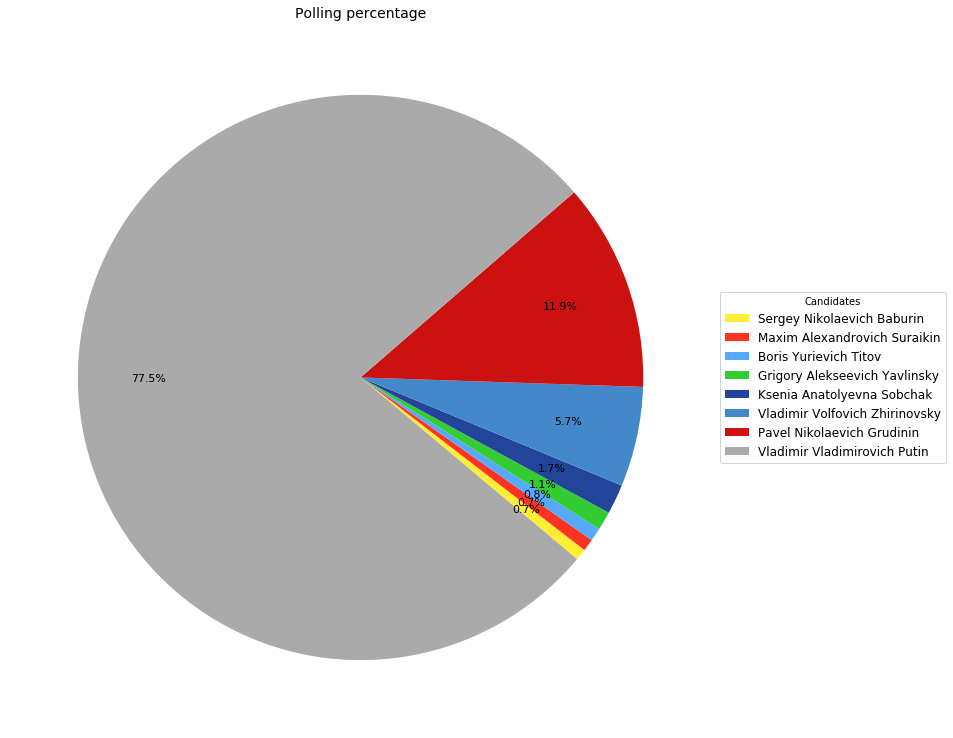

In [14]:
p_votes = (cand_df.nVotes / t_votes * 100).round(2).sort_values()

fig, ax = plt.subplots(figsize=(13, 13))

wedges, texts, autotexts = ax.pie(p_votes, 
                                  autopct=lambda pct: "{:.1f}%".format(pct),
                                  pctdistance=0.75,
                                  textprops=dict(color="w"), 
                                  colors=cand_df.Color[p_votes.index],
                                  startangle=-40)

ax.legend(wedges, cand_df.Name[p_votes.index], title="Candidates", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize='large')
plt.setp(autotexts, size=11, weight=500, color='black')
ax.set_title("Polling percentage", fontdict={'fontsize':14})
plt.show()

# Anomalies detection on turnout

### Histogram of polling stations across the country

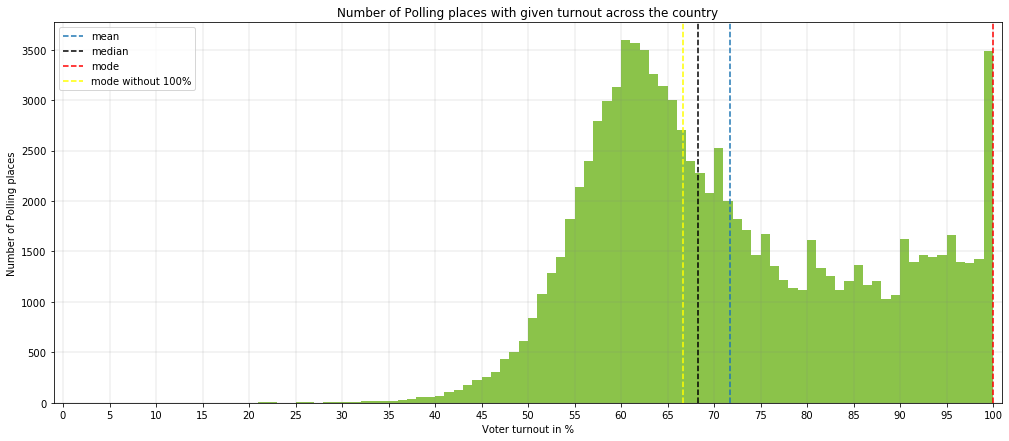

In [15]:
plt.figure(figsize=(17,7))
plt.hist(elect_df.appearance * 100, bins=100, color='#8BC34A')
plt.axvline(x=elect_df.appearance.mean() * 100, ls='--', label='mean')
plt.axvline(x=elect_df.appearance.median() * 100, c='black', ls='--', label='median')
plt.axvline(x=elect_df.appearance.mode()[0] * 100, c='red', ls='--', label='mode')
plt.axvline(x=elect_df.appearance[elect_df.appearance != 1.0].mode()[0] * 100, c='yellow', ls='--', label='mode without 100%')
plt.title('Number of Polling places with given turnout across the country')
plt.xlabel('Voter turnout in %')
plt.ylabel('Number of Polling places')
plt.xticks(np.linspace(0, 100, 21))
plt.xlim(-1,101)
plt.legend()
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

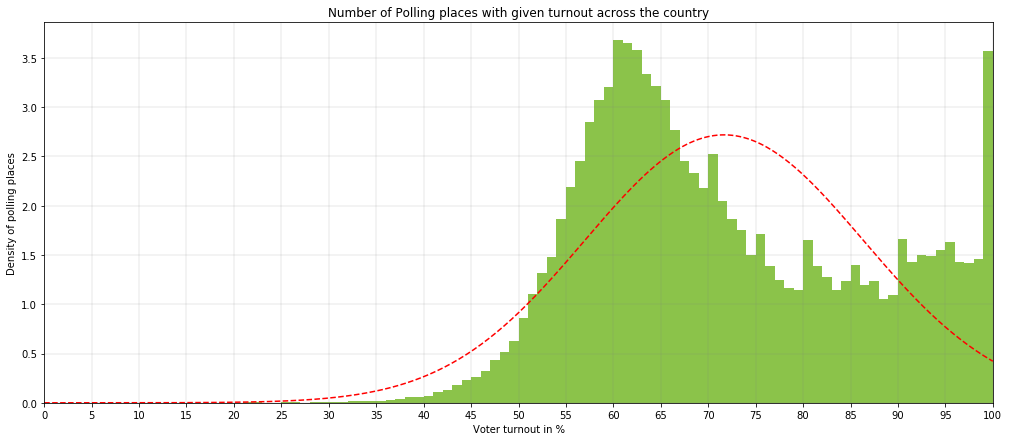

In [16]:
m, sig = elect_df.appearance.mean(), elect_df.appearance.std()

plt.figure(figsize=(17,7))
plt.hist(elect_df.appearance, bins=100, color='#8BC34A', density=True)
plt.plot(np.linspace(0, 1, 500), norm.pdf(np.linspace(0, 1, 500), m, sig), ls='--', c='red')
plt.title('Number of Polling places with given turnout across the country')
plt.xlabel('Voter turnout in %')
plt.ylabel('Density of polling places')
plt.xticks(np.linspace(0, 1, 21), np.linspace(0, 100, 21).astype(int))
plt.xlim(-0,1)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

Testing hypothesis $H_0$ that the data comes from Gaussian distribution.

In [17]:
s_stat, p = normaltest(elect_df.appearance)
alpha = 0.05
if p > alpha:
    print(f'p={p}: Fail to reject H0 with alpha={alpha}, data comes from Gaussian distribution')
else:
    print(f'p={p}: Reject H0 with alpha={alpha}, data does not come from Gaussian distribution')

p=0.0: Reject H0 with alpha=0.05, data does not come from Gaussian distribution


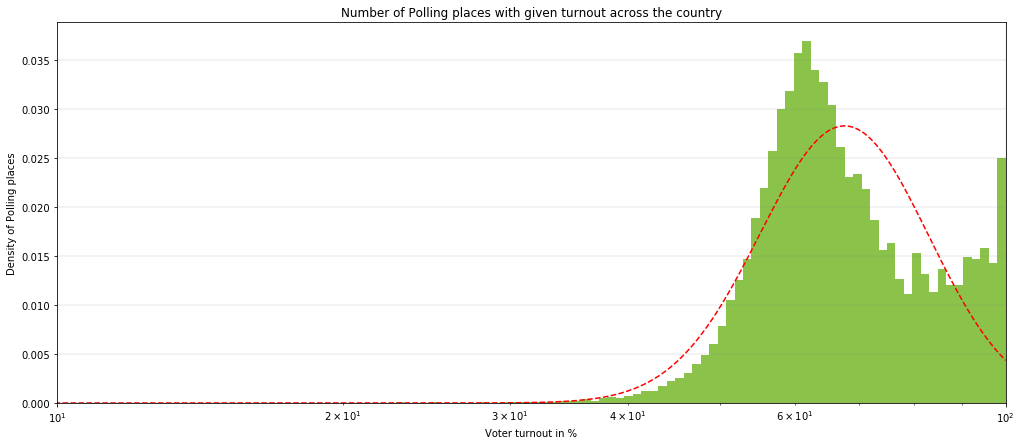

In [18]:
shape, location, scale = lognorm.fit(elect_df.appearance * 100)

plt.figure(figsize=(17,7))
plt.hist(elect_df.appearance * 100, bins=np.logspace(0,2,225), color='#8BC34A', density=True)
plt.xscale("log")
pdf = lognorm.pdf(np.linspace(0, 100, 500), shape, location, scale)

plt.plot(np.linspace(0, 100, 500),pdf, ls='--', c='red')

plt.title('Number of Polling places with given turnout across the country')
plt.xlabel('Voter turnout in %')
plt.ylabel('Density of Polling places')
plt.xlim(10,100)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

Testing hypothesis $H_0$ that the data comes from log-normal distribution.

In [19]:
s_stat, p = normaltest((elect_df.appearance).apply(lambda x:np.exp(x)))
alpha = 0.05
if p > alpha:
    print(f'p={p}: Fail to reject H0 with alpha={alpha}, data comes from log-normal distribution')
else:
    print(f'p={p}: Reject H0 with alpha={alpha}, data does not come from log-normal distribution')

p=0.0: Reject H0 with alpha=0.05, data does not come from log-normal distribution


### Distribution plot of turnout of polling stations with a step 0.1%

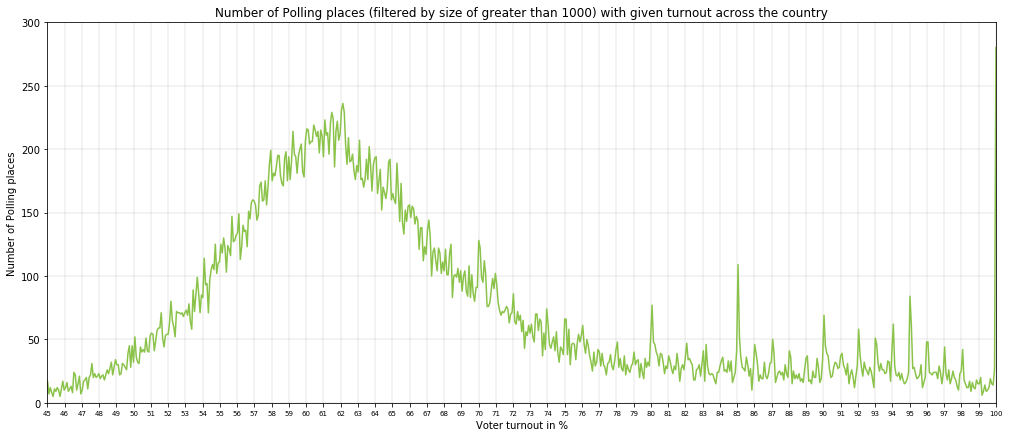

In [20]:
x,y = np.histogram(elect_df.appearance[elect_df[iVotersNum] > 1000], 1000)

plt.figure(figsize=(17,7))
plt.plot(y[1:] * 100, x, color='#8BC34A')
plt.title('Number of Polling places (filtered by size of greater than 1000) with given turnout across the country')
plt.xlabel('Voter turnout in %')
plt.ylabel('Number of Polling places')
plt.xticks(np.linspace(45, 100, 56), fontsize=7)
# plt.yticks(np.linspace(0, x.max(), 21))
plt.xlim(45,100)
plt.ylim(0, 300)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

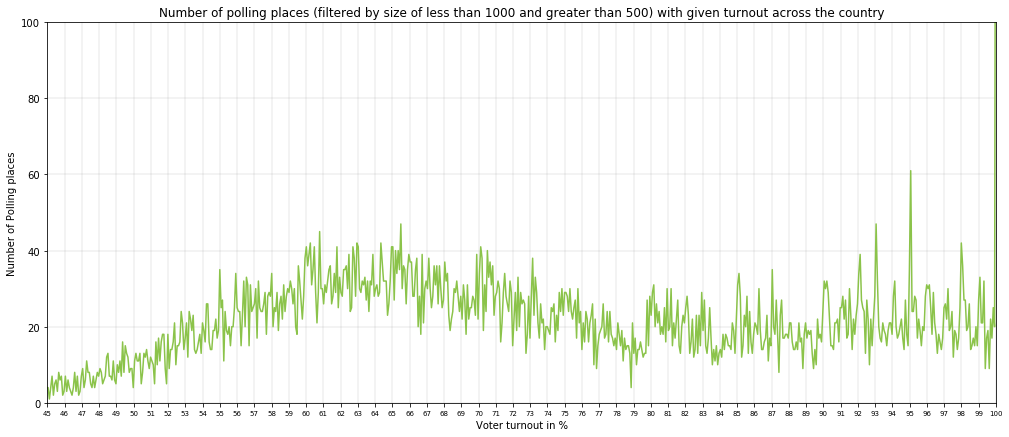

In [21]:
botl, topl = 500, 1000
x,y = np.histogram(elect_df[(elect_df[iVotersNum] < topl) & (elect_df[iVotersNum] > botl)].appearance, 1000)

plt.figure(figsize=(17,7))
plt.plot(y[1:] * 100, x, color='#8BC34A')
plt.title(f'Number of polling places (filtered by size of less than {topl} and greater than {botl}) with given turnout across the country')
plt.xlabel('Voter turnout in %')
plt.ylabel('Number of Polling places')
plt.xticks(np.linspace(45, 100, 56), fontsize=7)
# plt.yticks(np.linspace(0, x.max(), 21))
plt.xlim(45,100)
plt.ylim(0, 100)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

### Distribution plot of population related to specific turnout percentage with a step 0.1%

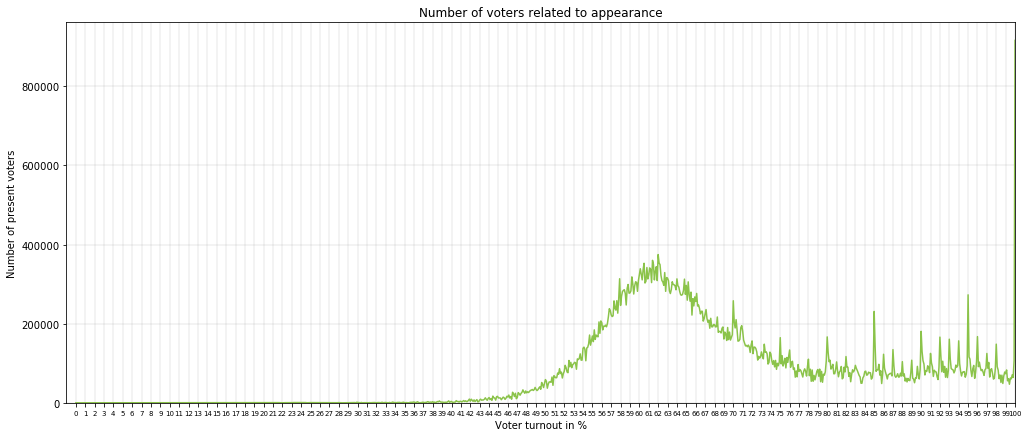

In [22]:
pick_df = elect_df[[iValidVotesNum, iInvalVotesNum, 'appearance']]
pick_df = pick_df.sort_values('appearance')
pick_df['appearance'] = pick_df['appearance'].round(3)
pick_df = pick_df.groupby('appearance').sum()
pick_df['size'] = pick_df.sum(axis=1)
pick_df = pick_df.drop(['10','9'], axis=1)

plt.figure(figsize=(17,7))
plt.plot(pick_df.index * 100, pick_df, color='#8BC34A')
plt.title('Number of voters related to appearance')
plt.xlabel('Voter turnout in %')
plt.ylabel('Number of present voters')
plt.xticks(np.linspace(0, 100, 101), fontsize=7)
# plt.yticks(np.linspace(0, x.max(), 21))
plt.xlim(-1,100)
plt.ylim(0)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.75)
plt.show()

### Nonparametric test

In [23]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [24]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [25]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [26]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

### Permutation test

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [27]:
x, _ = np.histogram(elect_df.appearance, 1000)
int_vals = x[500::10]
nint_vals = [x[ind] for ind in range(500, len(x)-1) if ind % 10 != 0]

p = permutation_test(int_vals, nint_vals, max_permutations = 50000)
alpha = 0.01
if p > alpha:
    print(f'p={p}: Fail to reject H0 with alpha={alpha}, both samples are taken from the same distribution')
else:
    print(f'p={p}: Reject H0 with alpha={alpha}, samples are taken from different distributions')

p=0.00448: Reject H0 with alpha=0.01, samples are taken from different distributions


# Votes share and turnout correlation detection

### Stack plot of votes share and voter turnout

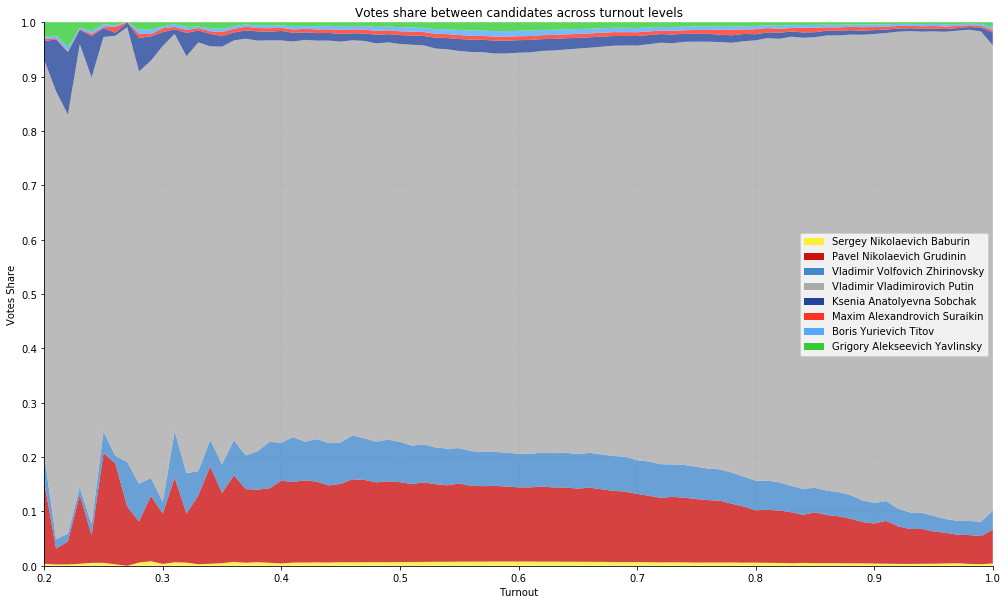

In [28]:
pick_df = elect_df[['appearance'] + list(candidates.keys())]
pick_df = pick_df.sort_values('appearance')
pick_df['appearance'] = pick_df['appearance'].round(2)
pick_df = pick_df.groupby('appearance').sum()
pick_df = pick_df.div(pick_df.sum(axis=1), axis=0)
pick_df = pick_df.fillna(0)

fig, ax = plt.subplots(figsize=(17,10))

# Plot for each column
ax = plt.gca()
ax.stackplot(pick_df.index.values, pick_df.values.T, labels=candidates.values(), colors=cand_colors, alpha=0.8)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Turnout')
ax.set_ylabel('Votes Share')
ax.set_title('Votes share between candidates across turnout levels')
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim(0.2)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.25)
legend = plt.legend(markerscale=5, loc='center right')
for lhand in legend.legendHandles: 
    lhand.set_alpha(1)
plt.show()

### Scatter plots of votes share and voter turnout

Scatter plot reveals a correlation between votes share and voter turnout

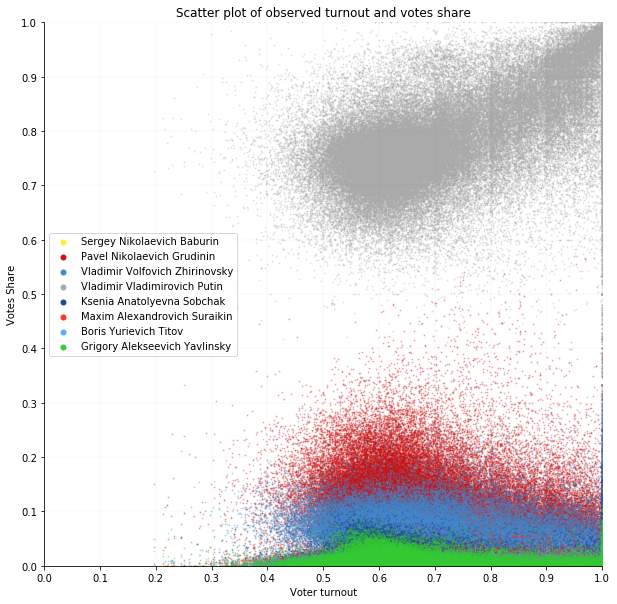

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

for cand_ind,col in zip(candidates, cand_colors):
    ax.scatter(elect_df.appearance, elect_df[cand_ind] / elect_df[iValidVotesNum], s=1, c=col, alpha=0.25, label=candidates.get(cand_ind))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Scatter plot of observed turnout and votes share')
ax.set_xlabel('Voter turnout')
ax.set_ylabel('Votes Share')
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.25)
legend = plt.legend(markerscale=5)
for lhand in legend.legendHandles: 
    lhand.set_alpha(1)
plt.show()

Applying linear regression to voter turnout and votes share data

D:\Science\Python\Programs\ProjectDataCollection\venv\lib\site-packages\IPython\core\pylabtools.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


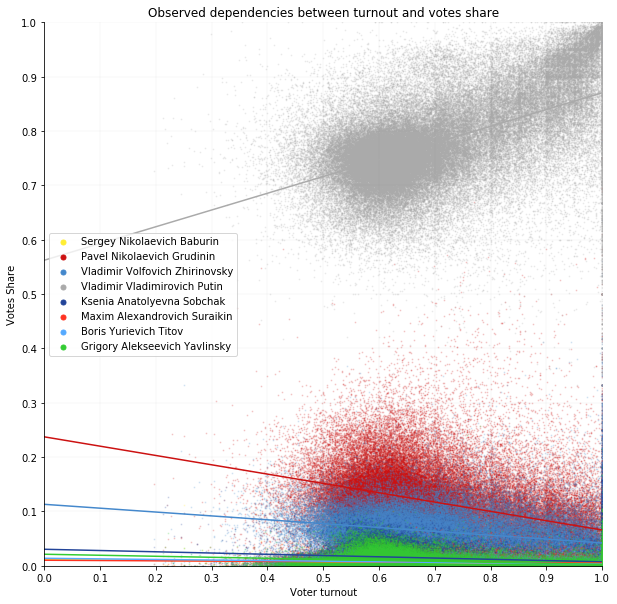

In [30]:
fig, ax = plt.subplots(figsize=(10,10))

cand_lin_reg = LinearRegression()
sorted_appearance = elect_df.appearance.sort_values()

for cand_ind,col in zip(candidates, cand_colors):
    votes_share = elect_df[cand_ind] / elect_df[iValidVotesNum]
    ax.scatter(elect_df.appearance, votes_share, s=1, c=col, alpha=0.15, label=candidates.get(cand_ind))
    cand_lin_reg.fit(elect_df.appearance.values.reshape(-1, 1), votes_share.fillna(0))
    ax.plot(sorted_appearance, cand_lin_reg.predict(sorted_appearance.values.reshape(-1, 1)), c=col)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Observed dependencies between turnout and votes share')
ax.set_xlabel('Voter turnout')
ax.set_ylabel('Votes Share')
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.25)
legend = plt.legend(markerscale=5)
for lhand in legend.legendHandles: 
    lhand.set_alpha(1)
plt.show()

Confidence intervals for coefficients of linear regression models of every candidate

In [31]:
import statsmodels.formula.api as smf

for cand_ind in candidates:
    votes_share = elect_df[cand_ind] / elect_df[iValidVotesNum]
    mod = smf.ols('voteshare ~ Turnout_slope', data=pd.DataFrame(np.array([elect_df.appearance.values, votes_share.fillna(0)]).T, columns=['Turnout_slope', 'voteshare']))
    res = mod.fit()
    print (candidates.get(cand_ind), res.conf_int(0.05),'\n')   # 99% confidence interval

Sergey Nikolaevich Baburin                       0         1
Intercept      0.011367  0.011757
Turnout_slope -0.007809 -0.007276 

Pavel Nikolaevich Grudinin                       0         1
Intercept      0.235443  0.239052
Turnout_slope -0.173881 -0.168949 

Vladimir Volfovich Zhirinovsky                       0         1
Intercept      0.111985  0.114221
Turnout_slope -0.072585 -0.069529 

Vladimir Vladimirovich Putin                       0         1
Intercept      0.559681  0.564483
Turnout_slope  0.304791  0.311355 

Ksenia Anatolyevna Sobchak                       0         1
Intercept      0.029960  0.030866
Turnout_slope -0.023698 -0.022460 

Maxim Alexandrovich Suraikin                       0         1
Intercept      0.010027  0.010463
Turnout_slope -0.005542 -0.004946 

Boris Yurievich Titov                       0         1
Intercept      0.013613  0.014027
Turnout_slope -0.010983 -0.010418 

Grigory Alekseevich Yavlinsky                       0         1
Intercept      0

Observation of density between voter turnout and votes share for the leader candidate

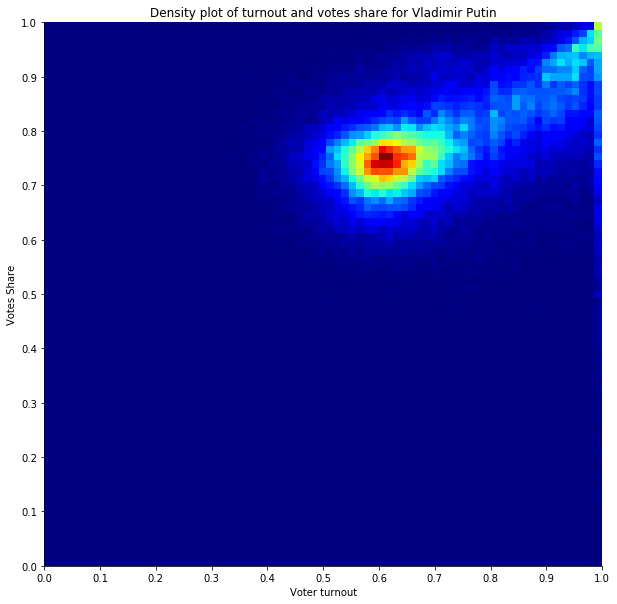

In [32]:
fig, ax = plt.subplots(figsize=(10,10))


ax.hist2d(elect_df.appearance, (elect_df[iPutin] / elect_df[iValidVotesNum]).fillna(0), bins=(75, 75), cmap=plt.cm.jet)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Density plot of turnout and votes share for Vladimir Putin')
ax.set_xlabel('Voter turnout')
ax.set_ylabel('Votes Share')
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
plt.show()

# Observation of fraud regions distributions

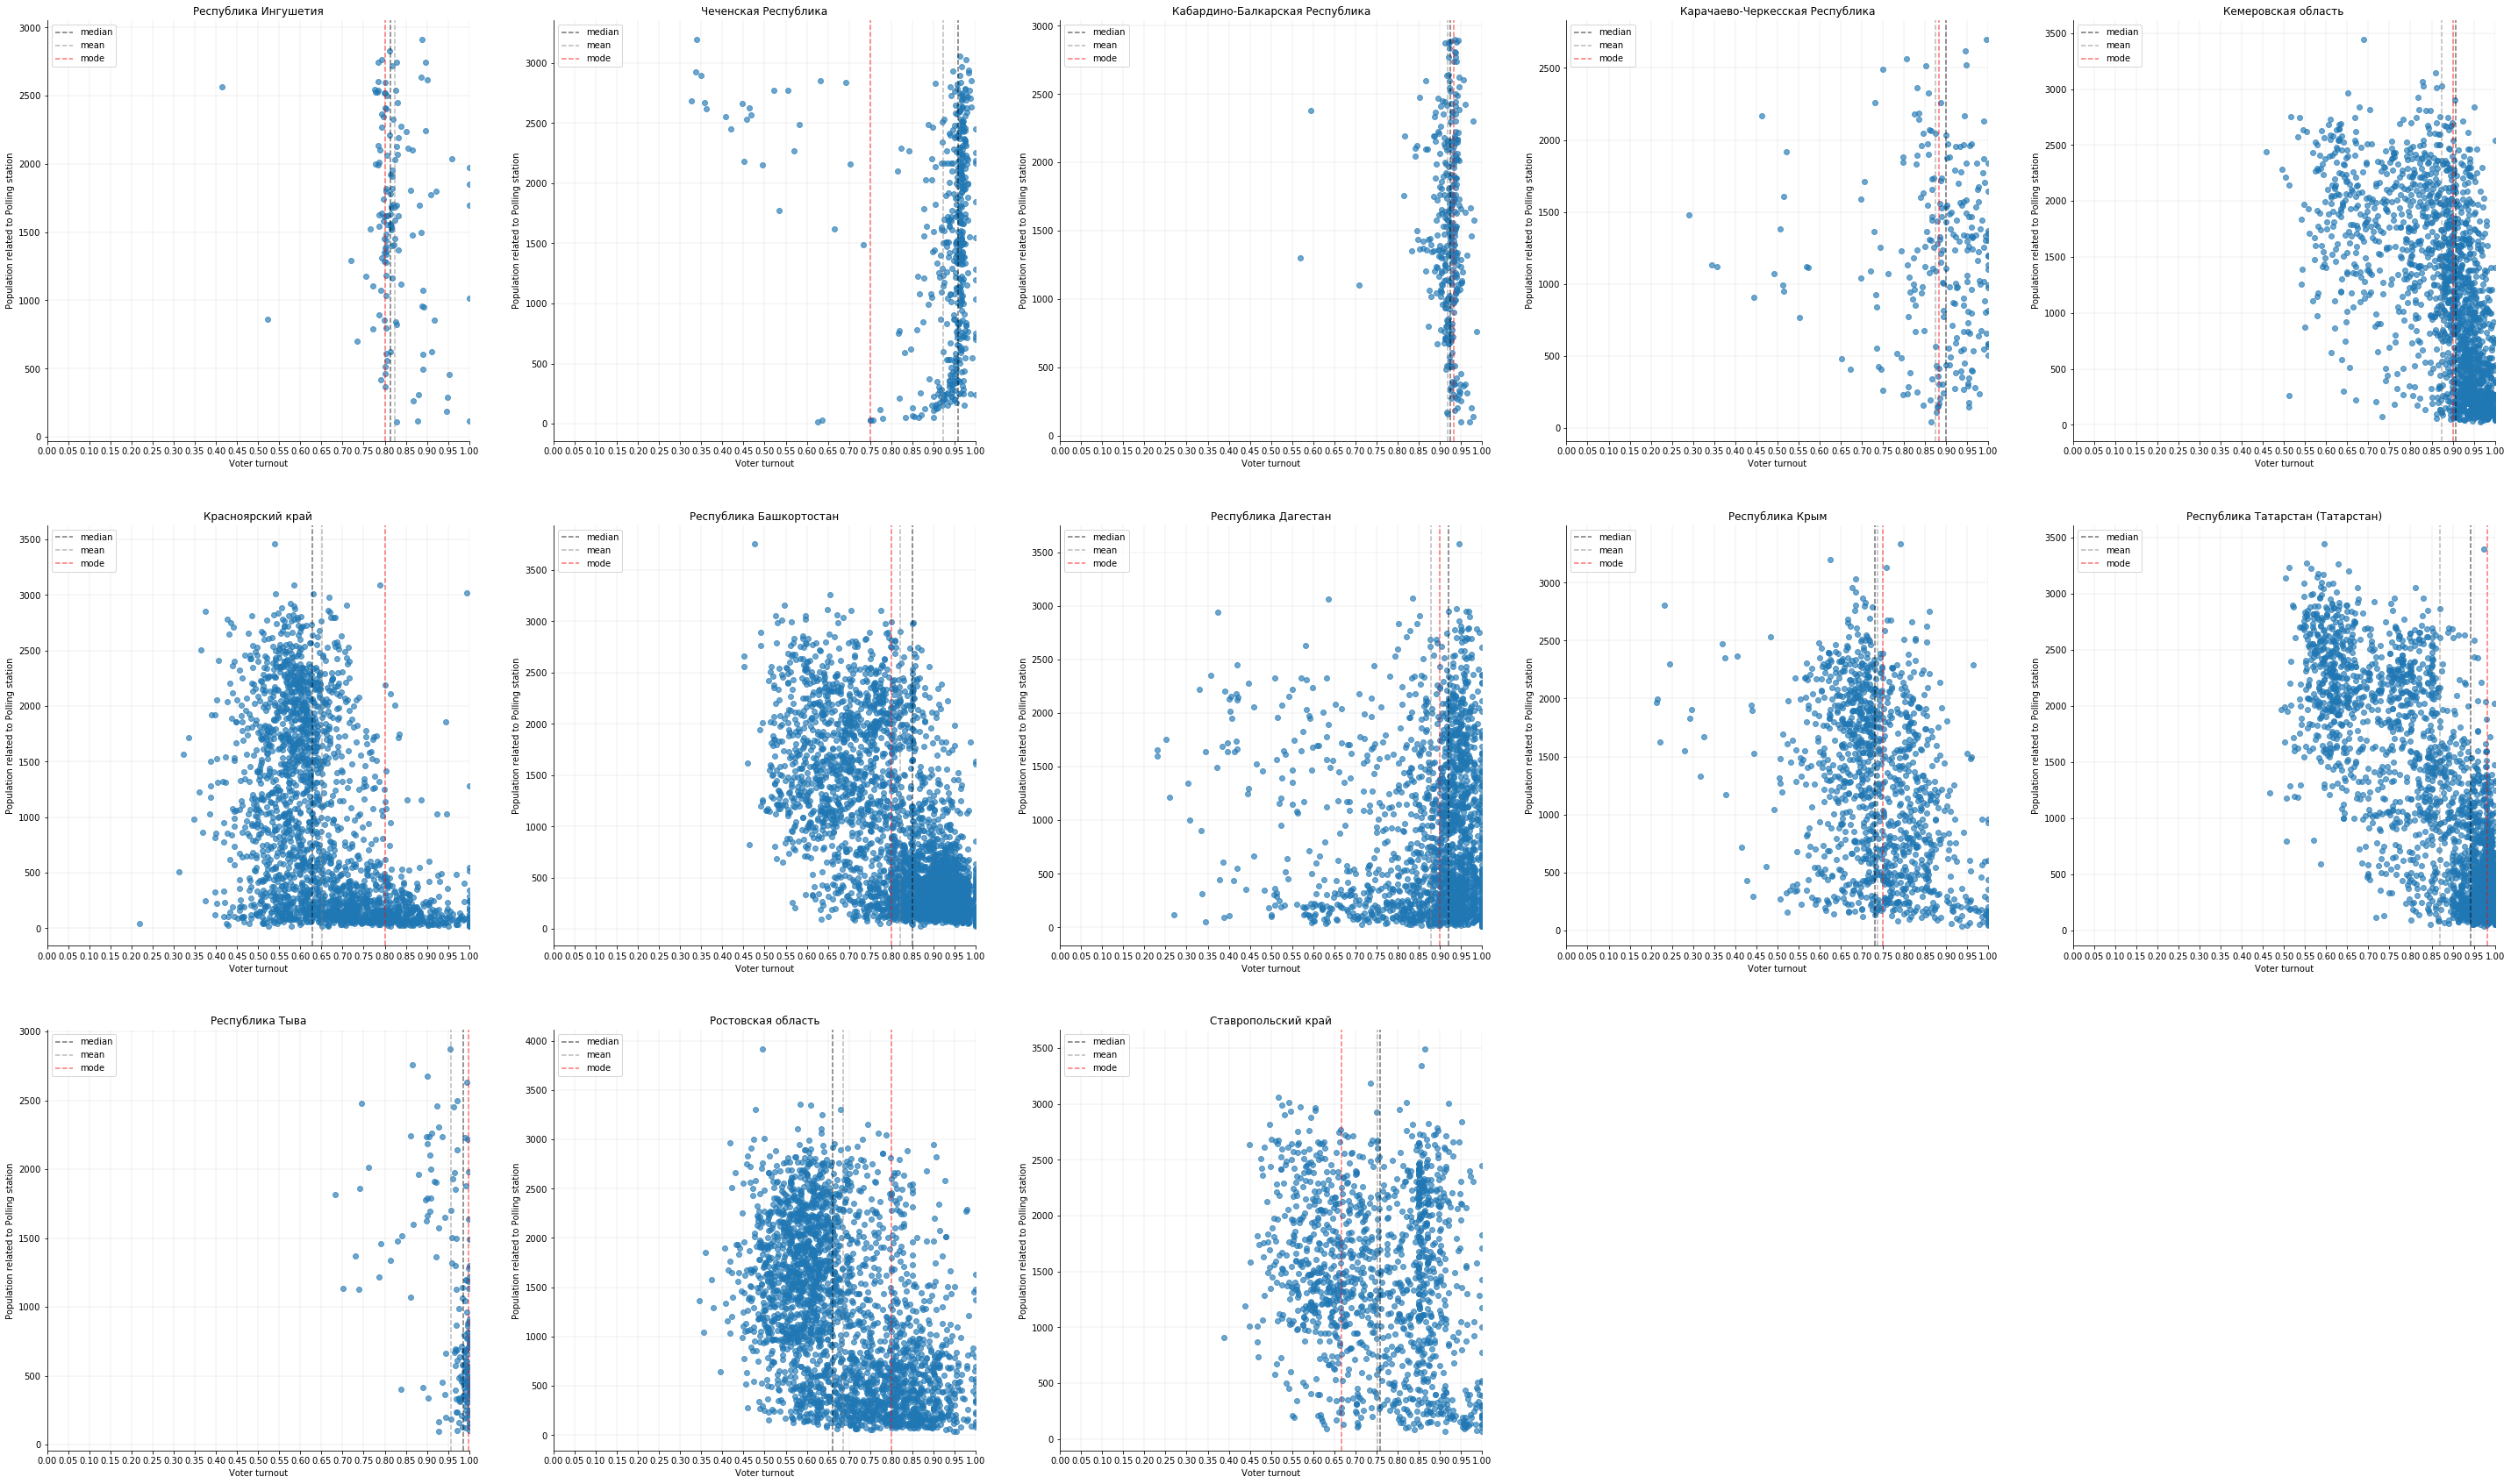

In [33]:
regtp = ['Республика Ингушетия', 'Чеченская Республика', 
         'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика', 
         'Кемеровская область', 'Красноярский край', 'Республика Башкортостан', 
         'Республика Дагестан', 'Республика Крым', 'Республика Татарстан (Татарстан)', 
         'Республика Тыва', 'Ростовская область', 'Ставропольский край']
rows = 3
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(10*cols,10*rows))

for i in range(len(regtp)):
    region_subdf = elect_df[elect_df.kom1 == regtp[i]]
    ax[i//cols, i%cols].axvline(x=region_subdf.appearance.median(), c='black', ls='--', alpha=0.55, label='median')
    ax[i//cols, i%cols].axvline(x=region_subdf.appearance.mean(), c='grey', ls='--', alpha=0.55, label='mean')
    ax[i//cols, i%cols].axvline(x=region_subdf.appearance[region_subdf.appearance<1].mode()[0], c='red', ls='--', alpha=0.55, label='mode')
    ax[i//cols, i%cols].scatter(region_subdf.appearance, region_subdf[iVotersNum], alpha=0.65)
    ax[i//cols, i%cols].set_xlim(0, 1)
    # ax.set_ylim(0, 1)
    ax[i//cols, i%cols].spines['top'].set_visible(False)
    ax[i//cols, i%cols].spines['right'].set_visible(False)
    ax[i//cols, i%cols].set_title(regtp[i])
    ax[i//cols, i%cols].set_xlabel('Voter turnout')
    ax[i//cols, i%cols].set_ylabel('Population related to Polling station')
    ax[i//cols, i%cols].set_xticks(np.linspace(0, 1, 21))
    # ax.set_yticks(np.linspace(0, 1, 11))
    ax[i//cols, i%cols].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax[i//cols, i%cols].legend(loc='upper left')
ax[-1, -1].axis('off')
ax[-1, -2].axis('off')
plt.show()